In [72]:
import os 
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
import math

import load_cifar10

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score


In [2]:
X_train_raw, y_train_raw, X_test_raw, y_test_raw = load_cifar10.load_cifar10_data(as_array=True)

Data loaded succesfully!


In [3]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [ ]:
# Create X_val set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, 
                                                  y_train_raw, 
                                                  test_size=0.2,
                                                  random_state=13)


# Define Search Space

In [5]:
n_hidden_layers = [1, 2, 4]
n_neurons_x_layer = [50, 200, 1000]
learning_rate = [10**-3, 10**-4, 10**-5]
activation = 'relu'
solver='adam'

# se hacen todas las combinaciones
architectures = list(product(n_hidden_layers, n_neurons_x_layer, learning_rate))
print('Total of architectures:', len(architectures))



Total of architectures: 27


## One-Epoch Training

In [133]:
def one_epoch_train_mlp(architectures, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Trains and evaluates multiple MLP configurations and returns results in a DataFrame.
    
    Parameters:
    ----------
    configurations : list of tuples
        Each tuple contains (hidden_layers, n_neurons, learning_rate)
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_val : array-like
        Validation features
    y_val : array-like
        Validation labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
        
    Returns:
    -------
    pandas.DataFrame
        DataFrame containing results for all configurations
    """
    
    # Initialize the dict for the results
    configuration_results = {
        'hidden_layers': [],
        'n_neurons': [],
        'learning_rate': [],
        'train_time': [],
        'train_score': [],
        'val_score': [],
        'test_score': [],  
        'confusion_matrices': [],
    }

    for i, (h, n, lr) in enumerate(architectures):
        print(i + 1, '/', len(architectures))
        print('Hidden Layers: {}, # Neurons: {}, Learning rate: {}'.format(h, n, lr))
        # definir estructura de neurona
        neuron_structure = (np.ones(h) * n).astype(int)

        # Entrenar NN
        mlp = MLPClassifier(
            hidden_layer_sizes=(neuron_structure),
            activation='relu',
            solver='adam',
            learning_rate_init=lr
        )

        # Start timing
        start_time = time.time()
        
        # Train for one epoch
        mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

        # Calculate time taken
        total_train_time = time.time() - start_time
        # Calculate accuracies
        train_accuracy = mlp.score(X_train, y_train)
        val_accuracy = mlp.score(X_val, y_val)
        y_val_pred = mlp.predict(X_val)  # Predict once

        # Confusion matrix
        best_cm = confusion_matrix(y_val, y_val_pred)

        # Calculate test accuracy
        test_accuracy = mlp.score(X_test, y_test)

        # Print results
        print(f"Training Time: {total_train_time:.4f} seconds")
        # print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        # print(f"Test Accuracy: {test_accuracy:.4f}")

        # Se almacenan los resultados en el dict
        configuration_results['hidden_layers'].append(h)
        configuration_results['n_neurons'].append(n)
        configuration_results['learning_rate'].append(lr)
        configuration_results['train_time'].append(total_train_time)
        configuration_results['train_score'].append(train_accuracy)
        configuration_results['val_score'].append(val_accuracy)
        configuration_results['test_score'].append(test_accuracy)
        configuration_results['confusion_matrices'].append(best_cm)

    # Save the results to a dataframe
    architectures_df = pd.DataFrame(configuration_results)
    
    return architectures_df

In [7]:
architectures_results = one_epoch_train_mlp(architectures, X_train, y_train, X_val, y_val, X_test_scaled, y_test_raw)

# Save the results to a dataframe
architectures_df = pd.DataFrame(architectures_results)
architectures_df.to_excel('One_Epoch_Results.xlsx', index=False)

1 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.001
Training Time: 1.1786 seconds
Validation Accuracy: 0.4194
2 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.0001
Training Time: 1.0628 seconds
Validation Accuracy: 0.3727
3 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 1e-05
Training Time: 1.0953 seconds
Validation Accuracy: 0.2410
4 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.001
Training Time: 3.0978 seconds
Validation Accuracy: 0.4211
5 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.0001
Training Time: 3.0732 seconds
Validation Accuracy: 0.4202
6 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 1e-05
Training Time: 3.0388 seconds
Validation Accuracy: 0.2872
7 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.001
Training Time: 16.6214 seconds
Validation Accuracy: 0.4263
8 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.0001
Training Time: 14.9299 seconds
Validation Accuracy: 0.4504
9 / 27
Hidden Layers: 1, # Neurons: 

In [8]:
# Load architectures_results
# architectures_df = pd.read_excel('One_Epoch_Results.xlsx')

In [9]:
# Define metric to sort architectures by
metric = 'val_score'

In [134]:
def process_architecture_results(df, metric):
    """
    Creates unique IDs for neural network architectures and ranks them by a specified metric.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing neural network architecture configurations.
        Must have columns 'hidden_layers', 'n_neurons', and 'learning_rate'.
    
    metric : str
        The column name of the metric to use for ranking.
        Higher values are assumed to be better.
    
    Returns:
    --------
    pandas.DataFrame
        A copy of the input DataFrame with two new columns:
        - 'ID': A string combining the architecture parameters
        - 'Ranking': The rank of each architecture based on the metric
    """
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    # Create an ID for each architecture
    result_df['ID'] = (result_df['hidden_layers'].astype(str) + '_' + 
                       result_df['n_neurons'].astype(str) + '_' + 
                       result_df['learning_rate'].astype(str))
    
    # Sort by metric score
    result_df = result_df.sort_values(by=metric, ascending=False).reset_index(drop=True)
    
    # Add ranking
    result_df['Ranking'] = result_df.index + 1
    
    return result_df

In [11]:
architectures_df = process_architecture_results(architectures_df, metric)

## Early stopping after 50 epochs wo increment:

In [12]:
early_stop_results = pd.read_excel("50 Epochs wo Increase_Results.xlsx")
early_stop_results = process_architecture_results(early_stop_results, metric)

## Check the rankings of both

In [13]:
# Merge both to check positions
merged_results = pd.merge(architectures_df, early_stop_results, 
                          on='ID', suffixes=('_OE', '_ES')) # One Epoch, Early Stop
merged_results['val_score_diff'] = merged_results['val_score_OE'] - merged_results['val_score_ES']
merged_results['position_diff'] = merged_results['Ranking_OE'] - merged_results['Ranking_ES']

merged_results['val_score_diff'] = merged_results['val_score_OE'] - merged_results['val_score_ES']
display(merged_results[['ID', 'Ranking_OE', 'Ranking_ES']].head())

,ID,Ranking_OE,Ranking_ES
0,4_1000_0.0001,1,4
1,2_1000_0.0001,2,1
2,2_1000_0.001,3,8
3,1_1000_0.0001,4,5
4,4_1000_0.001,5,13


In [14]:
# Check the top elements in the ES and compare with OS
def get_top_models_overlap(df1, df2, id_column='ID', score_column='val_score', top_n=5):
    """
    Find how many models appear in the top N of both dataframes.
    
    Parameters:
    ----------
    df1 : pandas.DataFrame
        First dataframe containing OE results
    df2 : pandas.DataFrame
        Second dataframe containing ES results
    id_column : str
        Column name that uniquely identifies the models
    score_column : str, default='val_score'
        Column name that contains the scores to rank by
    top_n : int, default=5
        Number of top models to consider
        
    Returns:
    -------
    dict
        Dictionary containing:
        - count: Number of models that appear in top N of both dataframes
        - common_ids: Set of IDs that appear in top N of both dataframes
        - df1_in_df2: Models from df1 that are in top N of df2
        - df2_in_df1: Models from df2 that are in top N of df1
    """
    # Get top N models from each dataframe
    top_df1 = df1.nlargest(top_n, score_column)
    top_df2 = df2.nlargest(top_n, score_column)
    
    # Get the IDs of models in the top N
    top_ids_df1 = set(top_df1[id_column])
    top_ids_df2 = set(top_df2[id_column])
    
    # Find common IDs
    common_ids = top_ids_df1.intersection(top_ids_df2)
    
    # Get models from df1 that are in top N of df2
    df1_in_top_of_df2 = df1[df1[id_column].isin(top_ids_df2)]
    
    # Get models from df2 that are in top N of df1
    df2_in_top_of_df1 = df2[df2[id_column].isin(top_ids_df1)]
    
    return {
        'count': len(common_ids),
        'common_ids': common_ids,
        'df1_in_df2': df1_in_top_of_df2,
        'df2_in_df1': df2_in_top_of_df1
    }

In [15]:
overlap = get_top_models_overlap(architectures_df, early_stop_results)
print(overlap['count'])

3


# Multiple experiments testing

In [16]:
n_hidden_layers = [1, 2, 4]
n_neurons_x_layer = [50, 200, 1000]
learning_rate = [10**-3, 10**-4, 10**-5]
activation = 'relu'
solver='adam'

# se hacen todas las combinaciones
architectures = list(product(n_hidden_layers, n_neurons_x_layer, learning_rate))
print('Total of architectures:', len(architectures))

metric = 'val_score'

Total of architectures: 27


In [17]:
# Store results
overlap_results = []
dataframes_list = []

number_of_experiments = 50

for exp in range(number_of_experiments):
    print(f"Experiment {exp + 1} / {number_of_experiments}")
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_raw, 
                                                    test_size=0.2)

    architectures_results = one_epoch_train_mlp(architectures, X_train, y_train, X_val, y_val, X_test_scaled, y_test_raw)

    # Process and rank the results
    architectures_df = process_architecture_results(architectures_results, metric)
    dataframes_list.append(architectures_df)

    # Calculate overlap
    overlap = get_top_models_overlap(architectures_df, early_stop_results)
    overlap_results.append(overlap['count'])

# Concatenate all DataFrames at once
dataframes = pd.concat(dataframes_list, axis=0, ignore_index=True)
dataframes.to_excel('50 Experiments One Epoch.xlsx', index=False)

Experiment 1 / 50
1 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.001
Training Time: 1.1836 seconds
Validation Accuracy: 0.4198
2 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.0001
Training Time: 1.1277 seconds
Validation Accuracy: 0.3792
3 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 1e-05
Training Time: 1.1576 seconds
Validation Accuracy: 0.2100
4 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.001
Training Time: 3.1678 seconds
Validation Accuracy: 0.4210
5 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.0001
Training Time: 3.1278 seconds
Validation Accuracy: 0.4205
6 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 1e-05
Training Time: 3.2031 seconds
Validation Accuracy: 0.2923
7 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.001
Training Time: 15.0989 seconds
Validation Accuracy: 0.4260
8 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.0001
Training Time: 14.9449 seconds
Validation Accuracy: 0.4538
9 / 27
Hidden Laye

# Result Analysis

In [109]:
# toca pasarlo de string a un array
def string_to_matrix(matrix):

    clean_string = matrix.replace("[", "").replace("]", "").strip() 
    confusion_matrix = np.fromstring(clean_string, sep=' ').reshape((10, 10))
    confusion_matrix = confusion_matrix.astype(int)
    return confusion_matrix


In [110]:
experiments_result = pd.read_excel('50 Experiments One Epoch.xlsx')
experiments_result['confusion_matrices'] = experiments_result['confusion_matrices'].apply(string_to_matrix)
experiments_result.sample()

,hidden_layers,n_neurons,learning_rate,train_time,train_score,val_score,test_score,confusion_matrices,ID,Ranking
682,1,200,0.001,3.044763,0.4802,0.4318,0.4281,"[[382, 88, 71, 65, 70, 28, 21, 70, 170, 54], [...",1_200_0.001,8


In [111]:
# Calculate the average ranking for each architecture
average_rankings = experiments_result.groupby('ID')['Ranking'].mean().reset_index().sort_values('Ranking')

# Rename the columns for clarity
average_rankings.columns = ['Model ID', 'Average Ranking']

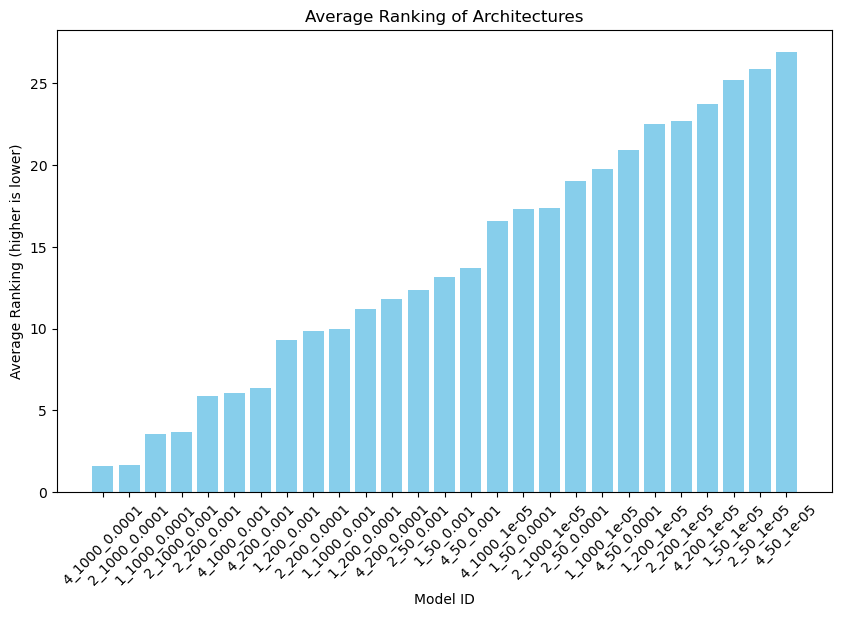

In [112]:
# Plot average ranking distribution
plt.figure(figsize=(10, 6))
plt.bar(x=average_rankings['Model ID'], 
        height=average_rankings['Average Ranking'], 
        color='skyblue')

plt.xlabel('Model ID')
plt.ylabel('Average Ranking (higher is lower)')
plt.title('Average Ranking of Architectures')

# Rotate x labels for better readability
plt.xticks(rotation=45)

plt.show()

In [113]:
experiments_result.columns

Index(['hidden_layers', 'n_neurons', 'learning_rate', 'train_time',
       'train_score', 'val_score', 'test_score', 'confusion_matrices', 'ID',
       'Ranking'],
      dtype='object')

In [114]:
def plot_correlation(data, var_1, var_2, ax=None):
    """
    Plots a scatter plot to visualize the correlation between two variables.

    Parameters:
    data (DataFrame): The DataFrame containing the data.
    var_1 (str): The name of the first variable.
    var_2 (str): The name of the second variable.
    ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure and axis will be created.
    """
    if ax is None:
        fig, ax = plt.subplots()  # Create a new figure and axis if none is provided

    ax.scatter(data[var_1], data[var_2])
    ax.set_title(f'Scatter of {var_1} vs {var_2}')
    ax.set_xlabel(var_1)
    ax.set_ylabel(var_2)
    ax.grid()

    if ax is None:  # Only show the plot if a new figure was created
        plt.show()

In [115]:
experiments_result

,hidden_layers,n_neurons,learning_rate,train_time,train_score,val_score,test_score,confusion_matrices,ID,Ranking
0,2,1000,0.00010,20.239761,0.526775,0.4746,0.4741,"[[571, 55, 27, 26, 18, 41, 22, 37, 121, 81], [...",2_1000_0.0001,1
1,4,1000,0.00010,31.280359,0.514375,0.4650,0.4763,"[[577, 70, 12, 26, 29, 30, 27, 38, 123, 67], [...",4_1000_0.0001,2
2,2,1000,0.00100,20.340099,0.494100,0.4595,0.4691,"[[525, 109, 29, 22, 27, 28, 31, 41, 126, 61], ...",2_1000_0.001,3
3,1,1000,0.00010,14.944926,0.501550,0.4538,0.4426,"[[466, 56, 33, 97, 34, 34, 22, 29, 145, 83], [...",1_1000_0.0001,4
4,2,200,0.00100,3.318244,0.478125,0.4418,0.4459,"[[545, 46, 73, 24, 11, 42, 34, 52, 126, 46], [...",2_200_0.001,5
...,...,...,...,...,...,...,...,...,...,...
1345,2,200,0.00001,3.154372,0.290375,0.2832,0.2879,"[[377, 58, 37, 32, 41, 37, 40, 52, 230, 100], ...",2_200_1e-05,23
1346,4,200,0.00001,3.460129,0.271975,0.2715,0.2726,"[[367, 38, 16, 35, 16, 63, 48, 28, 329, 64], [...",4_200_1e-05,24
1347,2,50,0.00001,1.081297,0.221300,0.2224,0.2218,"[[426, 141, 21, 25, 67, 60, 53, 5, 63, 143], [...",2_50_1e-05,25
1348,1,50,0.00001,1.062795,0.190675,0.1907,0.1938,"[[281, 36, 24, 3, 1, 28, 211, 0, 185, 235], [3...",1_50_1e-05,26


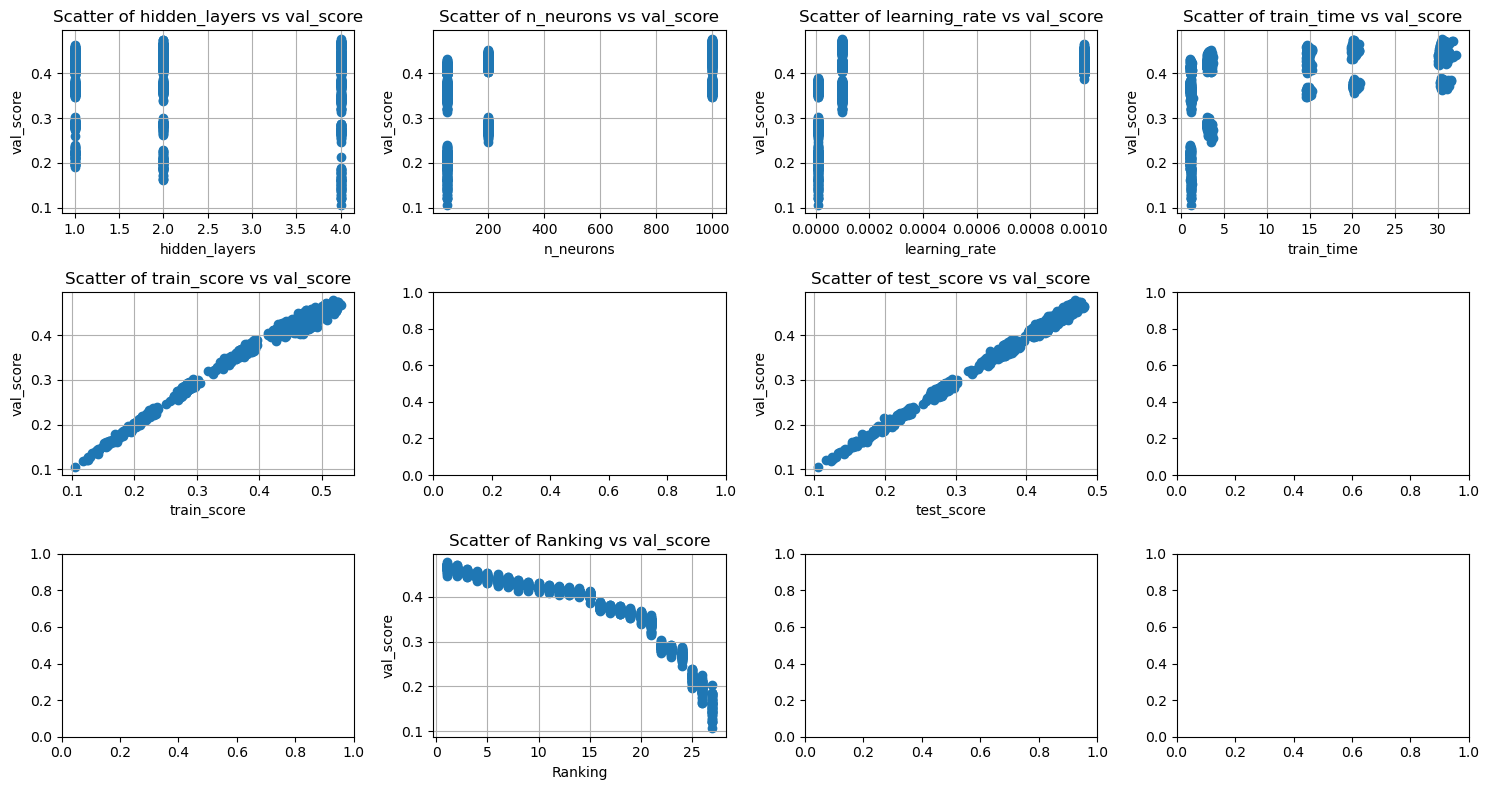

In [116]:
var_1 = 'hidden_layers'
var_2 = 'val_score'
fig, ax = plt.subplots(3, math.ceil(len(experiments_result.columns)//3 +1), figsize=(15, 8))
ax = ax.flatten()
for i, col in enumerate(experiments_result.columns):
    # print(f'Analyzing variable: {col}')
    if col in ['score', 'confusion_matrices', 'ID', var_2]:
        pass
    else:
        plot_correlation(experiments_result, col, var_2, ax=ax[i])

plt.tight_layout()

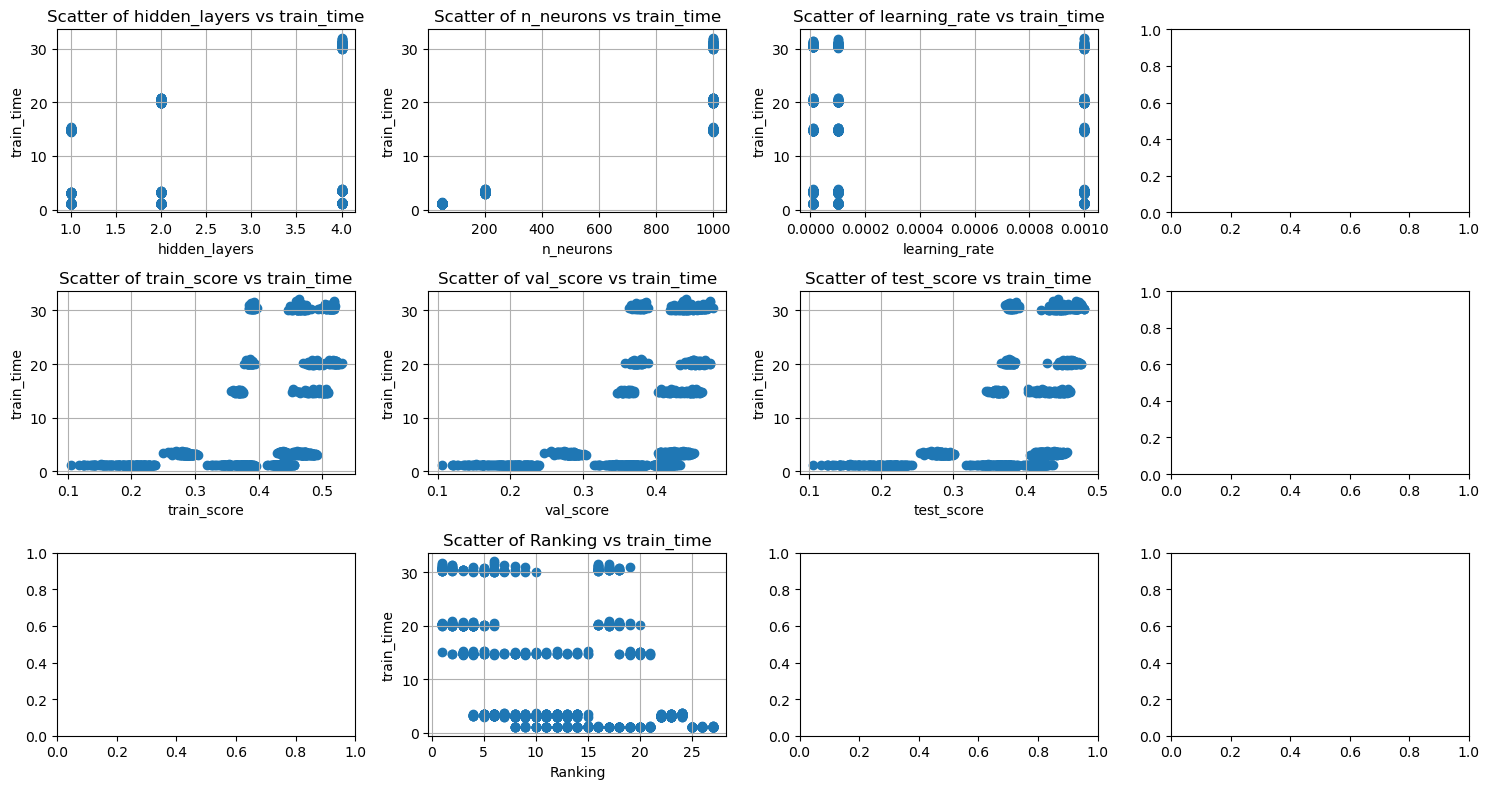

In [117]:
var_2 = 'train_time'
fig, ax = plt.subplots(3, math.ceil(len(experiments_result.columns)//3 +1), figsize=(15, 8))
ax = ax.flatten()
for i, col in enumerate(experiments_result.columns):
    # print(f'Analyzing variable: {col}')
    if col in ['confusion_matrices', 'ID', var_2]:
        pass
    else:
        plot_correlation(experiments_result, col, var_2, ax=ax[i])

plt.tight_layout()

In [118]:
experiments_result['confusion_matrices'].iloc[0]

array([[571,  55,  27,  26,  18,  41,  22,  37, 121,  81],
       [ 32, 599,  15,  18,  24,  19,  17,  43,  70, 183],
       [ 91,  45, 286,  55, 128,  99, 105,  91,  30,  29],
       [ 39,  74,  63, 286,  73, 207, 121,  74,  35,  57],
       [ 82,  35, 106,  41, 341,  65, 134, 109,  23,  44],
       [ 17,  36,  85, 159,  78, 400,  63, 103,  36,  39],
       [ 22,  44,  75,  78, 106,  85, 504,  46,  17,  35],
       [ 43,  28,  48,  44,  69,  63,  25, 548,  14,  63],
       [134,  67,  11,  21,  13,  25,  12,  17, 603, 102],
       [ 39, 177,  13,  17,  10,  27,  25,  54,  65, 608]])

In [122]:
def plot_cm(cm, axis=None):
    """
    Plots a confusion matrix using a heatmap.

    Parameters:
    cm (numpy.ndarray): The confusion matrix to plot.
    axis (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure is created.
    """
    if axis is None:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axis)
        axis.set_xlabel('Predicted Label')
        axis.set_ylabel('True Label')
        axis.set_title('Confusion Matrix')




learning_rate: 1e-05
learning_rate: 0.0001
learning_rate: 0.001


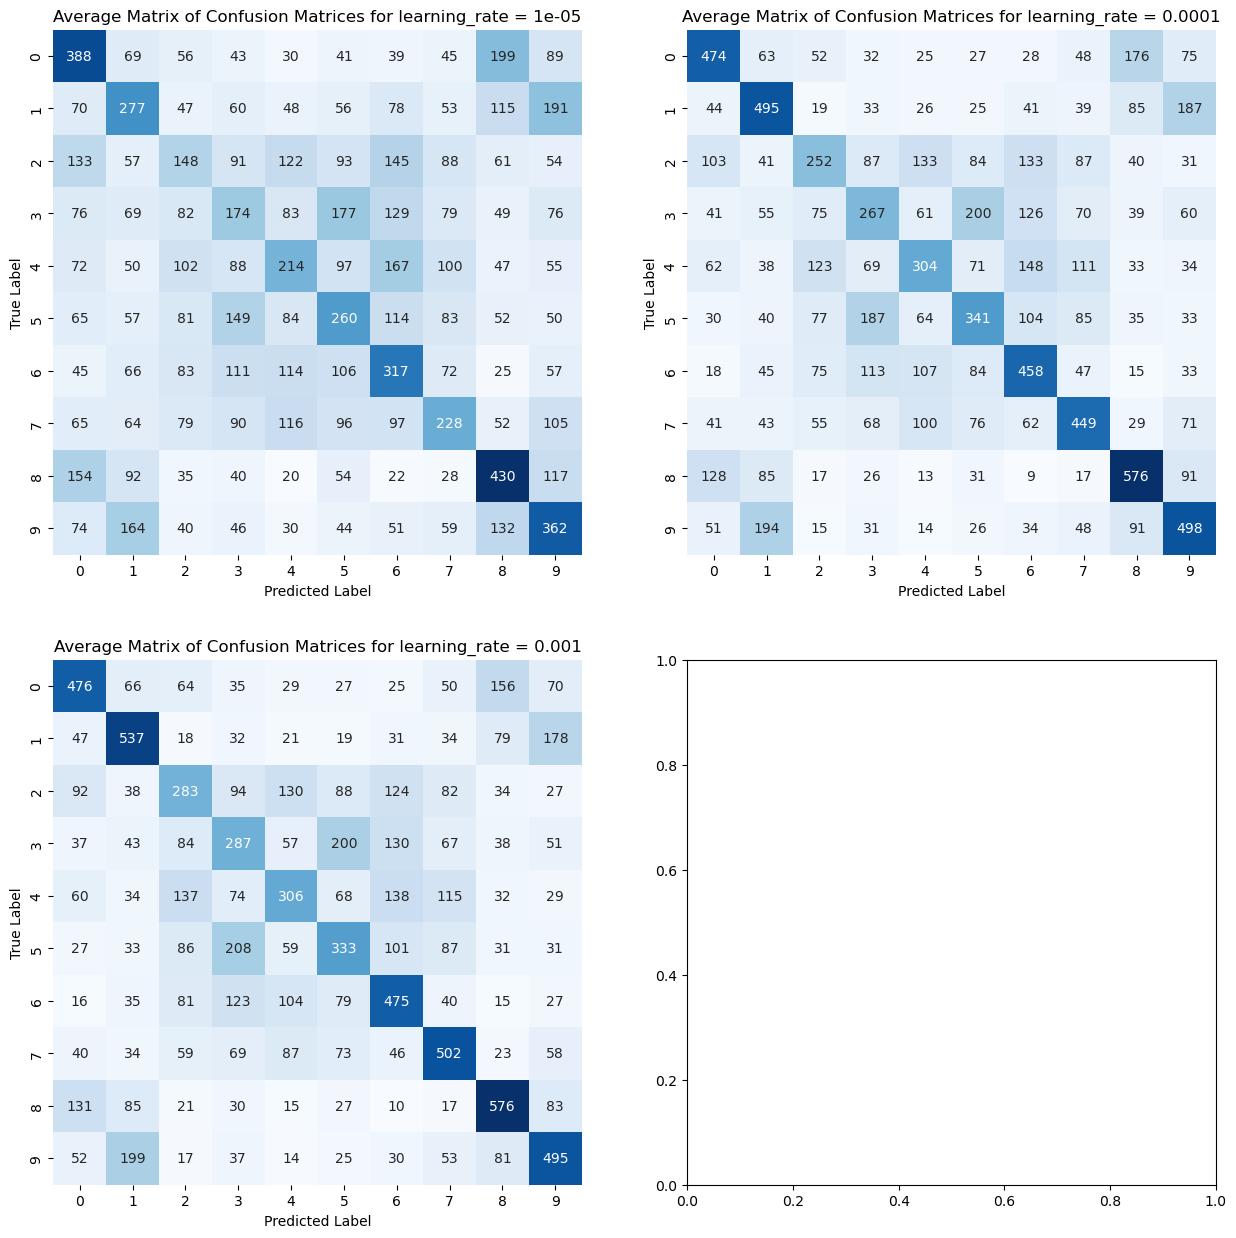

In [ ]:
var_to_test = 'learning_rate'
fig, ax = plt.subplots(len(experiments_result[var_to_test].unique())//2 + 1, 2, figsize=(15, 15))
ax = ax.flatten()
for i, lr in enumerate(sorted(experiments_result[var_to_test].unique())):
    print(f'{var_to_test}: {lr}')
    lr_df = experiments_result[experiments_result[var_to_test] == lr]
    mean_matrix = np.mean(lr_df['confusion_matrices']).astype(int)
    plot_cm(mean_matrix, axis=ax[i])
    ax[i].set_title(f'Average Matrix of Confusion Matrices for {var_to_test} = {lr}')


In [136]:
metric = 'val_score'

In [137]:
early_stop_results = pd.read_excel("50 Epochs wo Increase_Results.xlsx")
early_stop_results = process_architecture_results(early_stop_results, metric)